In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import datetime
import matplotlib.pyplot as plt
from shapely.wkt import loads as wkt_loads
import tifffile as tiff

from keras import backend as K
# from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
from shapely.wkt import loads
import shapely.wkt ## for the manipulation of planar features
import shapely.affinity
from collections import defaultdict
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import gc
import warnings
import zipfile
warnings.filterwarnings("ignore")
from keras.models import load_model
import tensorflow as tf
import random as rn
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tqdm import tqdm ## for the progress meter

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dstl-satellite-imagery-feature-detection/train_geojson_v3.zip
/kaggle/input/dstl-satellite-imagery-feature-detection/grid_sizes.csv.zip
/kaggle/input/dstl-satellite-imagery-feature-detection/sixteen_band.zip
/kaggle/input/dstl-satellite-imagery-feature-detection/train_wkt_v4.csv.zip
/kaggle/input/dstl-satellite-imagery-feature-detection/sample_submission.csv.zip
/kaggle/input/dstl-satellite-imagery-feature-detection/three_band.zip


In [2]:
os.mkdir('/kaggle/data')
os.mkdir('/kaggle/msk')
os.mkdir('/kaggle/model_weights')
os.mkdir('/kaggle/subm')

In [3]:
os.mkdir('/kaggle/x_tr_a')
os.mkdir('/kaggle/x_tr_na')
os.mkdir('/kaggle/y_tr_a')
os.mkdir('/kaggle/y_tr_na')

os.mkdir('/kaggle/x_val_a')
os.mkdir('/kaggle/x_val_na')
os.mkdir('/kaggle/y_val_a')
os.mkdir('/kaggle/y_val_na')

os.mkdir('/kaggle/x_test_a')
os.mkdir('/kaggle/x_test_na')
os.mkdir('/kaggle/y_test_a')
os.mkdir('/kaggle/y_test_na')

In [4]:
## reading the wkt files
wkt_df = pd.read_csv('../input/dstl-satellite-imagery-feature-detection/train_wkt_v4.csv.zip')

**Class Label**
1. Buildings - large building, residential, non-residential, fuel storage facility, fortified building
2. Misc. Manmade structures
3. Road
4. Track - poor/dirt/cart track, footpath/trail
5. Trees - woodland, hedgerows, groups of trees, standalone trees
6. Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
7. Waterway
8. Standing water
9. Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
10. Vehicle Small - small vehicle (car, van), motorbike

In [5]:
len(wkt_df['ImageId'].unique()) #Unique Images

## there are 25 total unqiue image ids

25

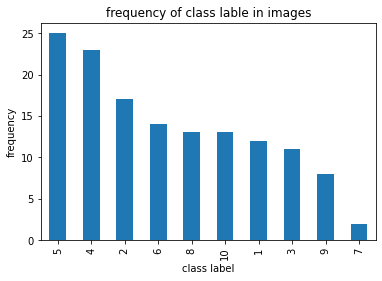

In [6]:
wkt_df[wkt_df['MultipolygonWKT']!='MULTIPOLYGON EMPTY']['ClassType'].value_counts()\
                      .plot.bar(title = 'frequency of class lable in images')
plt.xlabel('class label')
plt.ylabel('frequency')
plt.show()

In [7]:
# 3-Band images
def stretch2(band, lower_percent=2, higher_percent=98):
    a = 0 #np.min(band)
    b = 255  #np.max(band)
    c = np.percentile(band, lower_percent)
    d = np.percentile(band, higher_percent)        
    out = a + (band - c) * (b - a) / (d - c)    
    out[out<a] = a
    out[out>b] = b
    return out

def adjust_contrast(x):    
    for i in range(3):
        x[:,:,i] = stretch2(x[:,:,i])
    return x.astype(np.uint8)  

def display_img(ImageID): 
    #Read 3-band image
    rgbfile=os.path.join( 'three_band', '{}.tif'.format(ImageID))              
    rgb = tiff.imread(rgbfile)
    rgb = np.rollaxis(rgb, 0, 3)     

    x = adjust_contrast(rgb).copy()
    ax[1].imshow(x,extent=[0, 0.0092, -0.009, 0])

In [8]:
 #storing one multipoligon in pol
pol = loads(wkt_df['MultipolygonWKT'][11])

In [9]:
wkt_df['Multipolygons'] = wkt_df.apply(lambda a: loads(a.MultipolygonWKT), axis=1)
wkt_df['Num_Multipolygons'] = wkt_df.apply(lambda a: len(a['Multipolygons'].geoms), axis=1) 
objects_per_image = wkt_df.pivot(index='ClassType', columns='ImageId', values='Num_Multipolygons')

In [10]:
#class labels in dictionary as key and value pair
class_label = {
    1:'Buildings',
    2:'Misc. Manmade structures',
    3:'Road',
    4:'Track',
    5:'Trees',
    6:'Crops',
    7:'Waterway',
    8:'Standing water',
    9:'Vehicle Large',
    10:'Vehicle Small'
}

In [11]:
Classes = {1: 'Building', 2: 'Structure', 3: 'Road', 4: 'Track', 5: 'Trees', 6: 'Crops', 7: 'Waterway', 8: 'Standing water', 9: 'Truck', 10: 'Car'}
Colors = {1:'#d73027' , 2: '#f46d43', 3: '#4575b4', 4:'#74add1' , 5: '#dfc27d', 6: '#a6dba0', 7: '#1b7837', 8: '#b35806', 9: '0.4',  10: '0.7'}

In [12]:
def image_stats(image_id):
    '''
    creating dataframe which contains 
    classes, number of polygon as counts and total area of image with id image_id
    '''
    counts, total_area = {}, {}
    xmax = GS[GS.ImageId == image_id].Xmax.values[0]
    ymin = GS[GS.ImageId == image_id].Ymin.values[0]
    image_area = abs(xmax * ymin) #area of image
    for cl in Classes:
        all_poly = wkt_df[wkt_df.ImageId == image_id]
        poly = all_poly[all_poly.ClassType == cl].MultipolygonWKT
        poly_list = wkt_loads(poly.values[0])
        counts[cl] = len(poly_list)  #number of polygons of classtype cl

        if len(poly_list) > 0:
            #calculating area of all polygon for class cl having number of polygons more than one
            total_area[cl] = np.sum([poly.area for poly in poly_list])\
                             / image_area * 100 
   
    df = pd.DataFrame({'Class': Classes, 'Counts': counts,
                         'TotalArea': total_area})
    return df 

In [13]:
GS = pd.read_csv('../input/dstl-satellite-imagery-feature-detection/grid_sizes.csv.zip')
GS = GS.rename(columns={'Unnamed: 0':'ImageId'})
print(GS)

      ImageId      Xmax      Ymin
0    6120_2_4  0.009180 -0.009040
1    6120_2_3  0.009169 -0.009040
2    6120_2_2  0.009188 -0.009040
3    6120_2_1  0.009188 -0.009040
4    6120_2_0  0.009188 -0.009040
..        ...       ...       ...
445  6130_1_4  0.009169 -0.009040
446  6130_1_3  0.009188 -0.009040
447  6130_1_2  0.009150 -0.009042
448  6130_1_1  0.009004 -0.009045
449  6130_1_0  0.009188 -0.009040

[450 rows x 3 columns]


In [14]:
stats_list = []
Images = sorted(set(wkt_df['ImageId']))
for image_no, image_id in enumerate(Images):
    stat = image_stats(image_id)
    stat['ImageId'] = image_id
    stats_list.append(stat)
        
stats = pd.concat(stats_list)
pvt_stats = stats.pivot(index = 'Class', columns = 'ImageId', values = 'TotalArea')
percent_area = np.cumsum(pvt_stats, axis = 0)

class_r = {}
for cl in Classes:
    class_r[Classes[cl]] = cl

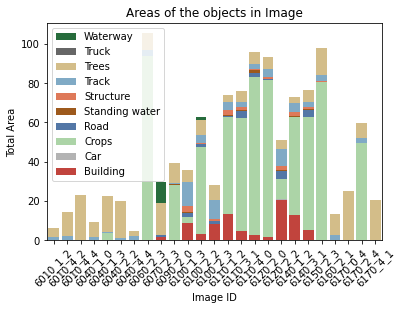

In [15]:
#iterating through all class to plot bar plot
import seaborn as sns
for cl in np.arange(1, 11):
    class_name = percent_area.index[-cl]
    class_id = class_r[class_name]
    ax = sns.barplot(x = percent_area.columns, y = percent_area.loc[class_name],
                         color = Colors[class_id], label = class_name)

sns.set_context({'figure.figsize': (12, 8)})
ax.legend(loc = 2)
sns.set_style("dark")
ax.set_xticklabels(percent_area.columns, rotation = 45)

ax.set_xlabel('Image ID')
ax.set_ylabel('Total Area')
plt.title('Areas of the objects in Image')
plt.show()

From the above graph we can see that 
1. Trees have highest area covered
2. After trees crops have highest area covered
3. Water and vehicles cover the less area

In [16]:
## we are having 10 classes
num_cls = 10

size = 160

#reduces and suppresses image noises
smooth = 1e-12
inDir = '../input/dstl-satellite-imagery-feature-detection'
TR = pd.read_csv(inDir + '/train_wkt_v4.csv.zip')
GS = pd.read_csv(inDir + '/grid_sizes.csv.zip', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)

#SF = pd.read_csv('/content/sample_submission.csv')
GS = GS.rename( columns={'Unnamed: 0':'ImageId'}) #rename 'ImageId'

In [17]:
## Adjusting the contrast of the image

def adjust_contrast(bands, lower_percent=2, higher_percent=98):
    """
    to adjust the contrast of the image 
    bands is the image 
    """
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # min(band)
        b = 1  # max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

In [18]:
## converting the coordinates into raster(pixels)
def coordi_to_raster(coords, img_size, xmax, ymax):
    
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / xmax
    yf = H1 / ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [19]:
## creating the image masks with mutliploygon objects using exterior and interior coordinates of the given multiploygon
def convert_contours(polygonList, raster_img_size, xmax, ymax):
    
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = coordi_to_raster(perim, raster_img_size, xmax, ymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = coordi_to_raster(interior, raster_img_size, xmax, ymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


In [20]:
# to generate the image masks using the image_size, image_id, class_type
def generate_mask_for_image_and_class(raster_size, image_id, class_type):

    xmax, ymax = GS[GS.ImageId == image_id].iloc[0, 1:].astype(float)

    df_image = TR[TR.ImageId == image_id]
    multipoly_def = df_image[df_image.ClassType == class_type].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    
    contours = convert_contours(polygonList, raster_size, xmax, ymax)

    img_mask = np.zeros(raster_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, 1)
    cv2.fillPoly(img_mask, interior_list, 0)

    return img_mask

In [21]:
## returns image pathces(crops) of given image and mask patch_size = 160*160 pixels
    
def get_patches(img, msk, name1, name2, name3, name4, amt, aug=True):
    random.seed(42)
    is2 = int(1.0 * size)

    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    a, b , c, d = [], [], [], []

    # thresholds for each class to get patches
    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    
    xyz = np.ceil(amt*0.10).astype(int)
    amt1 = amt-xyz
    amt2 = xyz

   # to get augmented data
    for i in range(amt1):

        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

     
        for j in range(num_cls):
            sm = np.sum(ms[:, :, j])

            if 1.0 * sm / is2 ** 2 > tr[j]:
               
                #augmentation
                if aug:
                    
                    # reversing
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]

                    #flipping 
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]
                    rotation = np.random.randint(4) # 0, 1, 2, 3

                    #transpose & rotation
                    if random.uniform(0, 1) > 0.5:
                       im = np.rot90(im.transpose((1,0,2)), k=rotation)
                       ms = np.rot90(ms.transpose((1,0,2)), k=rotation)
                    
                    #rotation
                    if random.uniform(0, 1) > 0.5:
                      im = np.rot90(im, k=rotation)
                      ms = np.rot90(ms, k=rotation)
                    
                    #shearing 
                    if random.uniform(0, 1) > 0.5:
                       im = tf.keras.preprocessing.image.apply_affine_transform(im, shear=0)
                       im = tf.keras.preprocessing.image.apply_affine_transform(im, shear=0)
                                     
                
                im = im.astype(np.float16)
                ms = ms.astype(np.float16)
                
                
                np.save("/kaggle/{}/{}".format(name1, i),im)  
                np.save("/kaggle/{}/{}".format(name2, i),ms)  
               
                a.append("/kaggle/{}/{}.npy".format(name1, i))
                b.append("/kaggle/{}/{}.npy".format(name2, i))

    # to get non-augmented data
    for i in range(amt2):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        im = im.astype(np.float16)
        ms = ms.astype(np.float16)
                                  
        np.save("/kaggle/{}/{}".format(name3, i),im)  
        np.save("/kaggle/{}/{}".format(name4, i),ms)  
                
        c.append("/kaggle/{}/{}.npy".format(name3, i))
        d.append("/kaggle/{}/{}.npy".format(name4, i))

    
    print(len(a), len(b))
    print(len(c), len(d))
  
    return a+c, b+d

In [22]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        #print(len(batch))
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size

class Dataset:
  
    def __init__(self, images_dir, mask_dir):
        
        self.ids = images_dir
        self.images_fps = images_dir
        self.masks_fps  = mask_dir
    
    def __getitem__(self, i):
        
        # read data
        image = np.load(self.images_fps[i]) 
        mask  = np.load(self.masks_fps[i])

          
        image = np.stack(image, axis=-1).astype('float')
        mask = np.stack(mask, axis=-1).astype('float')

        #image = np.transpose(image, (1,0,2)) 
        #mask = np.transpose(mask, (1,0,2)) 
    
        image = np.transpose(image, (0,2,1)) 
        mask = np.transpose(mask, (0,2,1)) 
  
        return image, mask
      
    def __len__(self):
        return len(self.ids)

In [23]:
## rgb image detection using M band
def M(image_id):
    zip_path = '../input/dstl-satellite-imagery-feature-detection/sixteen_band.zip'
    tgtImg = '{}_M.tif'.format(image_id)
    with zipfile.ZipFile(zip_path) as myzip:
        files_in_zip = myzip.namelist()
        for fname in files_in_zip:
            if fname.endswith(tgtImg):
                with myzip.open(fname) as myfile:
                    img = tiff.imread(myfile)
                    img = np.rollaxis(img, 0, 3)
                    return img
                
                

print ("combining all the images")
s = 835

X = np.zeros((5 * s, 5 * s, 8))
Y = np.zeros((5 * s, 5 * s, num_cls))  

ids = sorted(set(TR.ImageId))
print (len(ids))

for i in range(5):
    for j in range(5):
        id = ids[5 * i + j]

        rgb_img = M(id)
        img = adjust_contrast(rgb_img).copy()
        
        
        print (img.shape, id)
        X[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
        for z in range(num_cls):
            Y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

np.save('/kaggle/data/X', X)
np.save('/kaggle/data/Y', Y)
print(X.shape)
print(Y.shape)

combining all the images
25
(837, 849, 8) 6010_1_2
(837, 849, 8) 6010_4_2
(837, 848, 8) 6010_4_4
(837, 848, 8) 6040_1_0
(837, 848, 8) 6040_1_3
(837, 848, 8) 6040_2_2
(837, 846, 8) 6040_4_4
(837, 851, 8) 6060_2_3
(838, 835, 8) 6070_2_3
(837, 848, 8) 6090_2_0
(837, 848, 8) 6100_1_3
(837, 848, 8) 6100_2_2
(837, 848, 8) 6100_2_3
(837, 849, 8) 6110_1_2
(837, 849, 8) 6110_3_1
(837, 849, 8) 6110_4_0
(837, 851, 8) 6120_2_0
(837, 851, 8) 6120_2_2
(837, 849, 8) 6140_1_2
(837, 849, 8) 6140_3_1
(837, 851, 8) 6150_2_3
(837, 848, 8) 6160_2_1
(837, 848, 8) 6170_0_4
(837, 848, 8) 6170_2_4
(837, 848, 8) 6170_4_1
(4175, 4175, 8)
(4175, 4175, 10)


Splitting the dataset into training, validation and test dataset

In [24]:
#img, msk, name1, name2, name3, name4, amt, aug=True
#training the dataset
x_train, y_train = get_patches(X, Y, 'x_tr_a', 'y_tr_a', 'x_tr_na', 'y_tr_na', 20000, aug=True)

6262 6262
2000 2000


In [25]:
#validation dataset
x_val, y_val = get_patches(X, Y, 'x_val_a', 'y_val_a', 'x_val_na', 'y_val_na', 4000, aug=True)

1246 1246
400 400


In [26]:
#test dataset
x_test, y_test = get_patches(X, Y, 'x_test_a', 'y_test_na', 'x_test_a', 'y_test_na', 4000, aug=True)

1246 1246
400 400


In [27]:
train_dataset = Dataset(x_train, y_train)
train_dataloader = Dataloder(train_dataset, batch_size=8)
val_dataset = Dataset(x_val, y_val)
val_dataloader = Dataloder(val_dataset, batch_size=8)

In [28]:
train_dataloader[0][0].shape

(8, 160, 160, 8)

In [29]:
## calculating the jaccard coefficient
def jaccard_coef(y_true, y_pred):
    
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    total = K.sum(y_true + y_pred, axis=[0, -1, -2])
    union = total - intersection

    jac = (intersection + smooth) / (union+ smooth)

    return K.mean(jac)

In [38]:
##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)

def UNet():
    
    tf.random.set_seed(32)
    classes= 10
    img_input = Input(shape=(size, size, 8))
    x = img_input

    # Making the Encoder 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 23))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',  kernel_initializer = tf.keras.initializers.he_normal(seed= 43))(x)
   # x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 32))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 41))(x)
   # x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 33))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.5)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 35))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 54))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 39))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    #Making the Decoder
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 45))(x)
   # x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 41))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 49))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
      
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 18))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 21))(x)
    x = BatchNormalization()(x)
    x = Conv2D(classes, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 16))(x)
    x = Dropout(0.25)(x)
  
    x = Activation("softmax")(x)
    
    model = Model(img_input, x)
  
    model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=[jaccard_coef, 'accuracy'])
    return model

In [31]:
##changing the learning rates
def changeLearningRate(epoch):

    #lr=0.001
    lr=0.0001
    if epoch > 10 and epoch <=20:
      lr*=0.1
    elif epoch > 20 and epoch <=30:
      lr*=0.01
    elif epoch > 30 and epoch <=40:
      lr*=0.001
    elif epoch > 40 and epoch <=50:  
      lr*=0.0001
    elif epoch > 50 and epoch <=60:  
      lr*=0.0001  
    elif epoch > 60:
      lr*=0.0001

    return lr

In [32]:
## to stop the nueral network using callback functions

ACCURACY_THRESHOLD=0.502

class myCallback(tf.keras.callbacks.Callback): 
    
    def on_epoch_end(self, epoch, logs={}): 
        if (logs.get('val_jaccard_coef') > ACCURACY_THRESHOLD) and (logs.get('jaccard_coef') > ACCURACY_THRESHOLD):   
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True

stop = myCallback()

In [33]:
filepath="/kaggle/model_weights/weights-{epoch:02d}-{val_jaccard_coef:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [34]:
## to reduce the learning rate when the metric has stopped improving

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose = 1, min_delta = 0.0001)
lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)

In [40]:
model = UNet()

In [41]:
## summary of the U-NET model

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 8)]     0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 160, 160, 64)      4672      
_________________________________________________________________
batch_normalization_30 (Batc (None, 160, 160, 64)      256       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 160, 160, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 80, 80, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 80, 80, 128)       7385

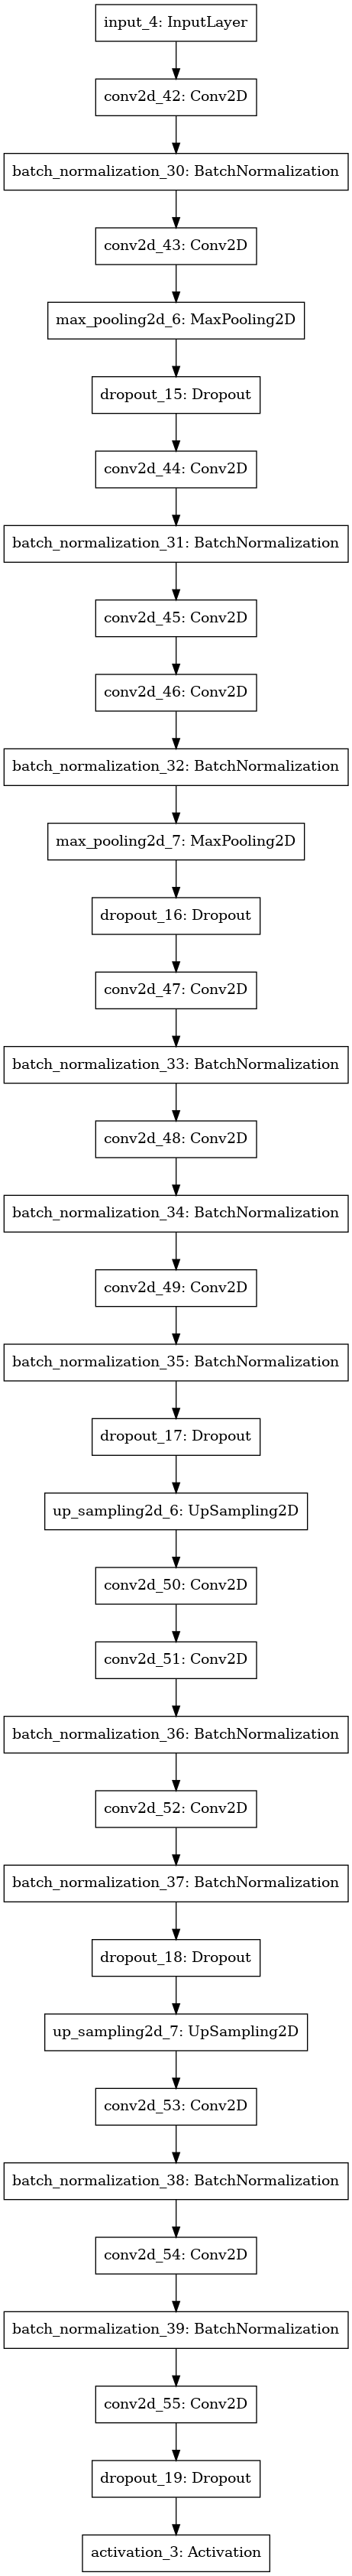

In [42]:
## U-NET Plot summary

tf.keras.utils.plot_model(model, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [44]:
##fitting the model

model_fitting = model.fit_generator(train_dataloader, 
                              steps_per_epoch=len(train_dataloader),
                              epochs=30,
                              validation_data=val_dataloader,
                              verbose=1,
                              callbacks=checkpoint
                              )

2022-06-30 04:23:29.123882: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-06-30 04:23:32.251035: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1032/1032 [==============================] - 125s 112ms/step - loss: 0.6886 - jaccard_coef: 0.0903 - accuracy: 0.5486 - val_loss: 0.6899 - val_jaccard_coef: 0.0518 - val_accuracy: 0.4934

Epoch 00001: val_loss improved from inf to 0.68985, saving model to /kaggle/model_weights/weights-01-0.0518.hdf5
Epoch 2/30
1032/1032 [==============================] - 107s 104ms/step - loss: 0.6835 - jaccard_coef: 0.1166 - accuracy: 0.5894 - val_loss: 0.6807 - val_jaccard_coef: 0.1443 - val_accuracy: 0.6610

Epoch 00002: val_loss improved from 0.68985 to 0.68067, saving model to /kaggle/model_weights/weights-02-0.1443.hdf5
Epoch 3/30
1032/1032 [==============================] - 107s 104ms/step - loss: 0.6813 - jaccard_coef: 0.1384 - accuracy: 0.6119 - val_loss: 0.6774 - val_jaccard_coef: 0.1541 - val_accuracy: 0.6849

Epoch 00003: val_loss improved from 0.68067 to 0.67739, saving model to /kaggle/model_weights/weights-03-0.1541.hdf5
Epoch 4/30
1032/1032 [==============================] - 108s 105ms/

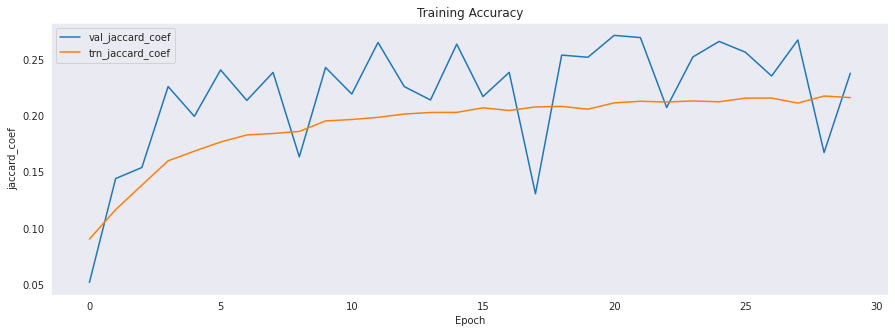

In [63]:
##plotting the training accuracy
plt.figure(figsize=(15,5))
plt.plot(range(model_fitting.epoch[-1]+1),model_fitting.history['val_jaccard_coef'],label='val_jaccard_coef')
plt.plot(range(model_fitting.epoch[-1]+1),model_fitting.history['jaccard_coef'],label='trn_jaccard_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('jaccard_coef');plt.legend(); 
plt.show()

In [64]:
test_dataset = Dataset(x_test, y_test)
test_dataloader = Dataloder(test_dataset, batch_size=1)

In [66]:
Score= []
for i in tqdm(range(len(test_dataloader))):
   pred_msk = model.predict(test_dataloader[i][0])
   score = jaccard_coef(test_dataloader[i][1], pred_msk)
   Score.append(score)

100%|██████████| 1646/1646 [01:44<00:00, 15.71it/s]


In [67]:
score = sum(Score)/len(test_dataloader)
print("The score obtained on the test data is: ", score.numpy())

The score obtained on the test data is:  0.037507387821899836


Performing Error Analysis

In [69]:
## total x and y values
total_x = x_train + x_val + x_test
total_y = y_train + y_val+ y_test

In [70]:
total_dataset = Dataset(total_x, total_y)
total_dataloader = Dataloder(total_dataset, batch_size=1)

In [71]:
## to compute the similarity between two objects using jaccard coefficient

Score= []
very_low_jaccard=[]
medium_jaccard= []
very_high_jaccard= []

for i in tqdm(range(len(total_dataloader))):

   pred_msk = model.predict(total_dataloader[i][0])
   score = jaccard_coef(total_dataloader[i][1], pred_msk)
   
   if score>0 and score <=0.20:
      very_low_jaccard.append(i)

   elif score>0.20 and score <=0.70:
      medium_jaccard.append(i)
   
   elif score>0.70 and score <=1:
      very_high_jaccard.append(i)

100%|██████████| 11554/11554 [12:17<00:00, 15.66it/s]


In [72]:
Very_low_jaccard_x = []
Medium_jaccard_x = []
Very_high_jaccard_x = []

Very_low_jaccard_y = []
Medium_jaccard_y = []
Very_high_jaccard_y = []

for i in very_low_jaccard:
   Very_low_jaccard_x.append(total_x[i])
for i in medium_jaccard:
   Medium_jaccard_x.append(total_x[i])
for i in very_high_jaccard:
   Very_high_jaccard_x.append(total_x[i])      

for i in very_low_jaccard:
   Very_low_jaccard_y.append(total_y[i])
for i in medium_jaccard:
   Medium_jaccard_y.append(total_y[i])
for i in very_high_jaccard:
   Very_high_jaccard_y.append(total_y[i])

In [73]:
np.save("vljx", Very_low_jaccard_x)
np.save("vljy", Very_low_jaccard_y)

In [74]:
vljx = np.load("vljx.npy")
vljy = np.load("vljy.npy")

In [75]:
## converting a mask image into polygons
    
def mask_to_polygons(mask, epsilon=5, min_area=1.):
    
    ##to detect objects in image
    contours, hierarchy = cv2.findContours(((mask == 1) * 255).astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()

    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1

    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])

    # creating actual polygons filtering it by area 
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
            
    # approximating polygons might have created invalid ones, fix them
    
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [76]:
DF  = pd.DataFrame(columns=["image", "class", "poly"])

for i in range(25):
   abcd = np.load(vljy[i])
   image, cl , ploy = [],[],[]
  
   for j in range(10):
     ab = mask_to_polygons(abcd[:,:,j], epsilon=1)
     image.append(i+1)
     cl.append(j+1)
     ploy.append(len(ab))
     df = pd.DataFrame(list(zip(image, cl, ploy)), columns = ['image', 'class', 'poly'])

   DF = pd.concat([DF,df], ignore_index=True)

In [77]:
objects_per_image = DF.pivot(index='class', columns='image', values='poly')

OBSERVATIONS

In [78]:
print("minimum value in an image",np.amin(np.load(vljx[0])))
print("maximum value in an image",np.amax(np.load(vljx[0])))

minimum value in an image 0.0
maximum value in an image 1.0


In [79]:
threshold = 0.4
Sum = []

for i in tqdm(range(25)):
   a = np.load(vljx[i])
   im= []
   for j in range(8):
     im.append(np.count_nonzero(np.less(a[:,:,j], threshold))) 
   x = sum(im)
   Sum.append(x)  
percentage = (sum(Sum)/(160*160*8*25))*100

100%|██████████| 25/25 [00:00<00:00, 234.71it/s]


In [80]:
## plotting the image
def plot_image(image_id):

  m = np.load(vljx[image_id])
  m = adjust_contrast(m)
  img = np.zeros((m.shape[0],m.shape[1],3))
  img[:,:,0] = m[:,:,4] #red
  img[:,:,1] = m[:,:,2] #green
  img[:,:,2] = m[:,:,1] #blue
  #plt.figure(figsize=(7,7))
  plt.imshow(img, interpolation='nearest')
  plt.show()

In [81]:
def plot_mask(mask_id):
  m = np.load(vljy[i])
  m = adjust_contrast(m)
  img = np.zeros((m.shape[0],m.shape[1],3)) 
  img[:,:,0] = m[:,:,4] #red
  img[:,:,1] = m[:,:,2] #green
  img[:,:,2] = m[:,:,1] #blue
  #plt.figure(figsize=(7,7))
  plt.imshow(img, interpolation='nearest')
  plt.show()

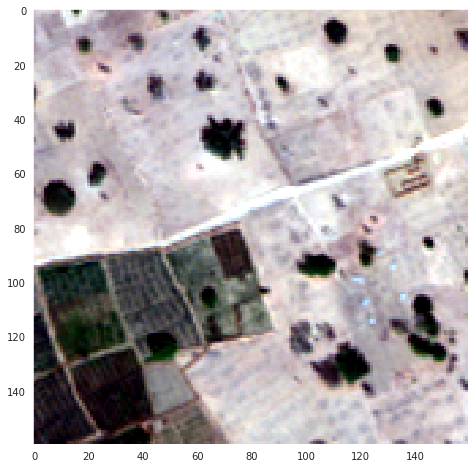

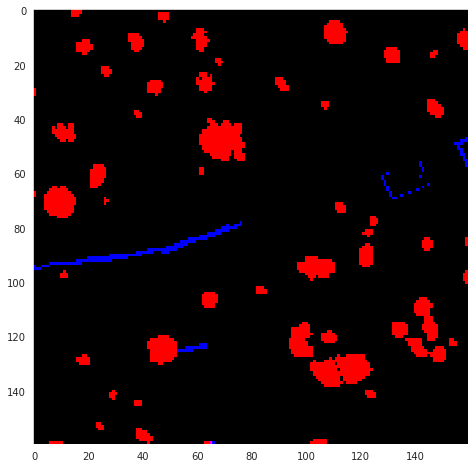

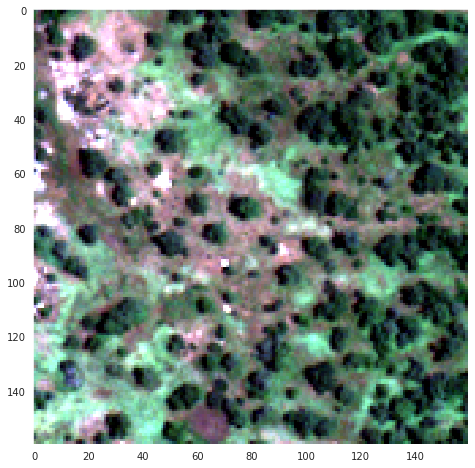

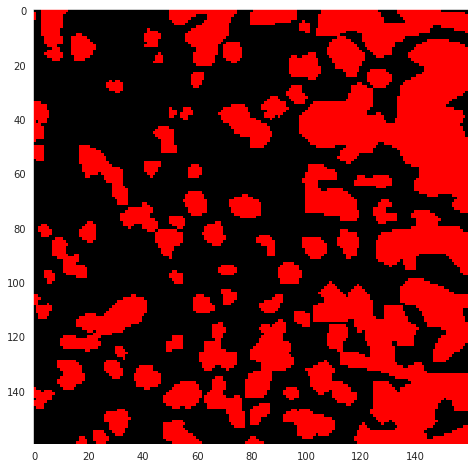

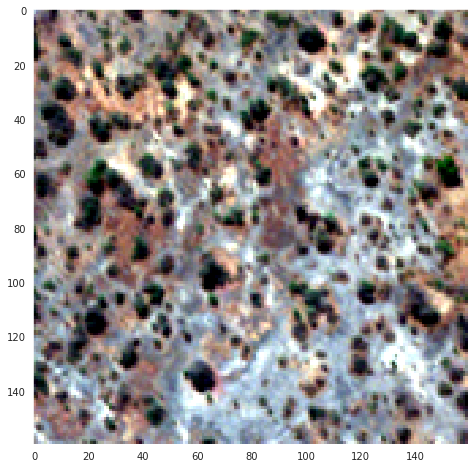

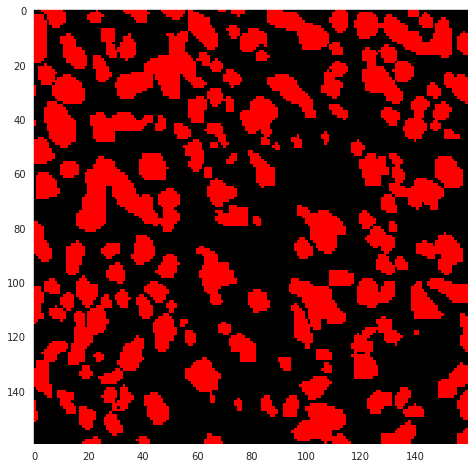

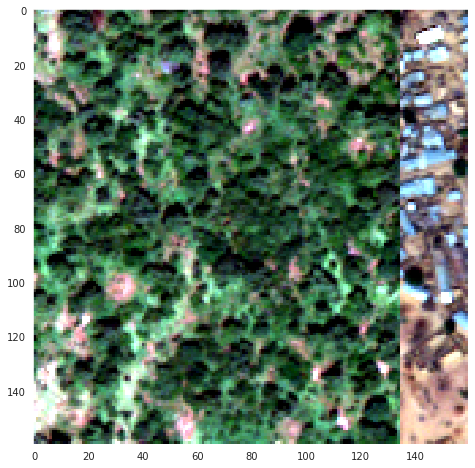

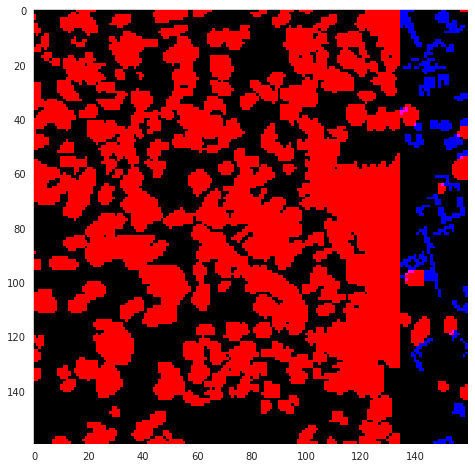

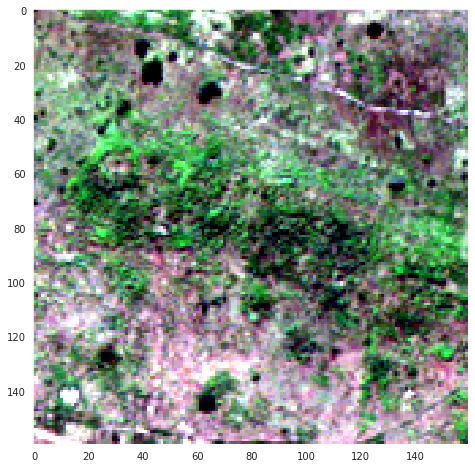

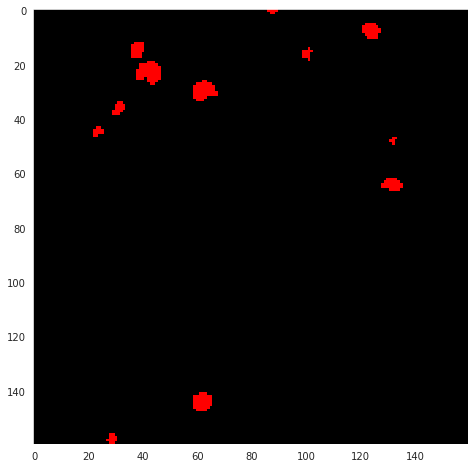

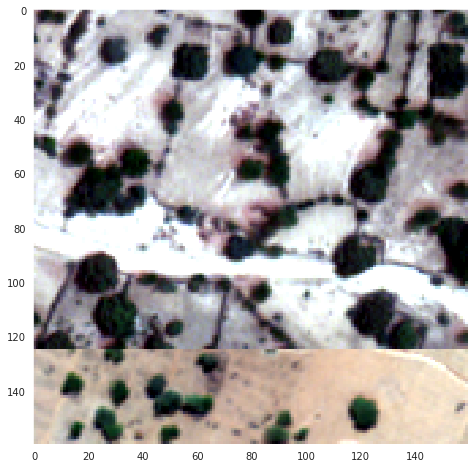

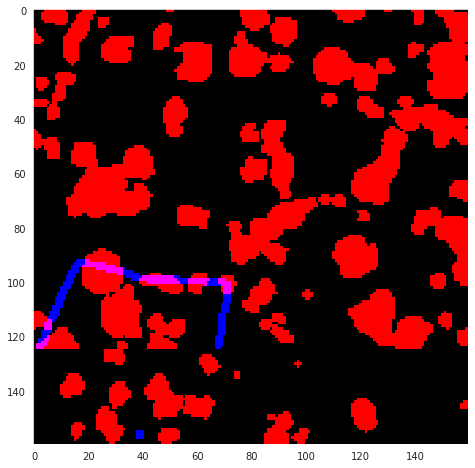

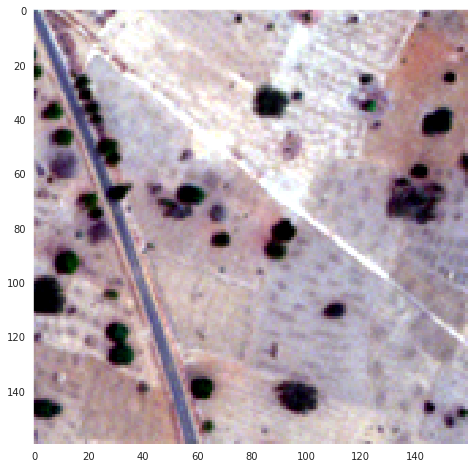

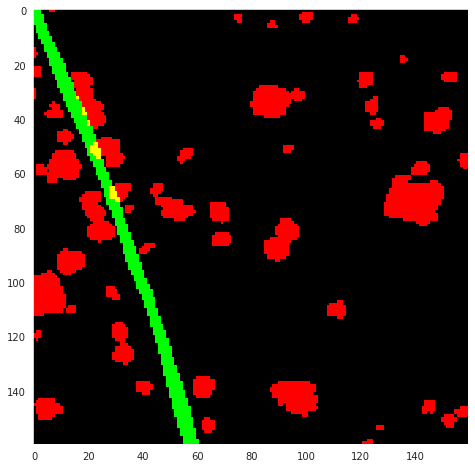

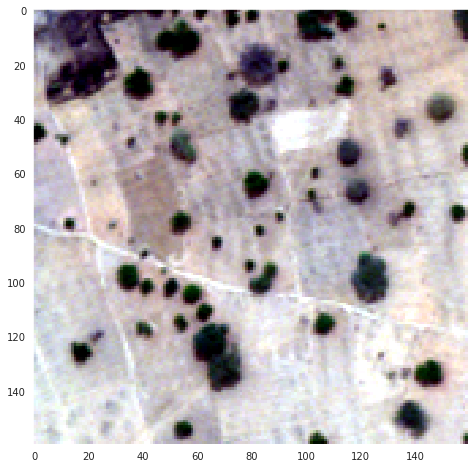

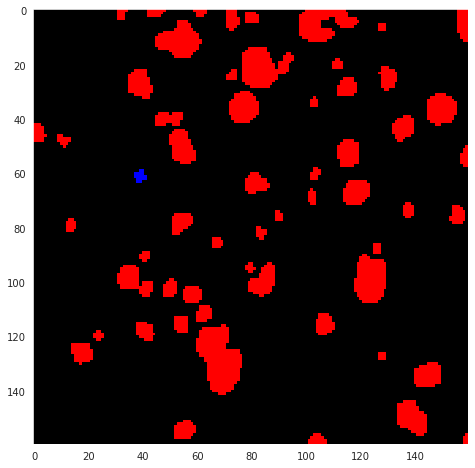

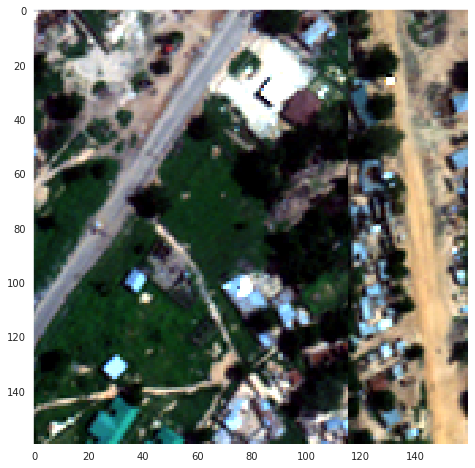

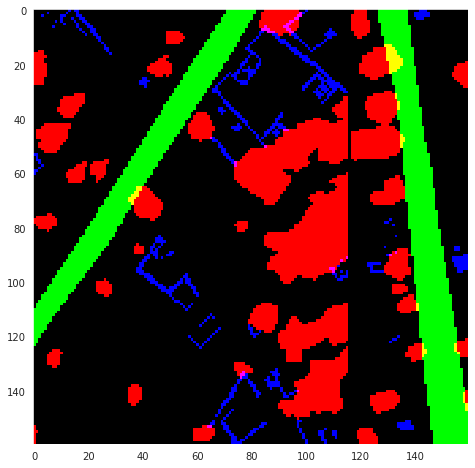

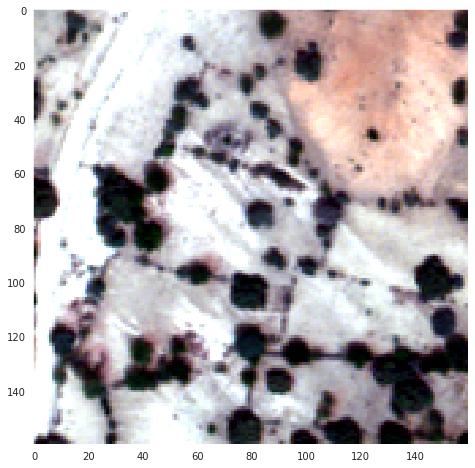

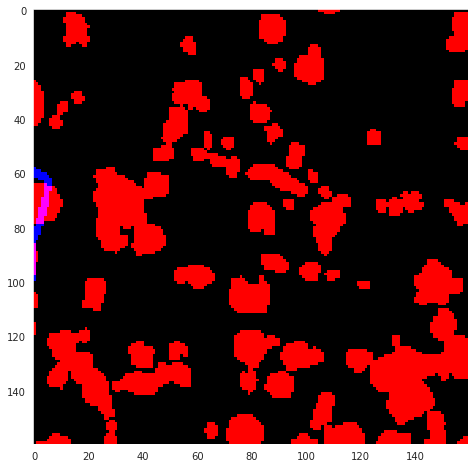

In [82]:
for i in range(10):
   plot_image(i)
   plot_mask(i)